# Capturing Blood Tissue in GTEx Data

**Gregory Way, 2018**

When viewing sample correlation differences across z dimensions stratified by tissue-type, we often observed a rapid increase in correlation after increasing model capacity by one.

For example, the ability of variational autoencoders to capture blood tissue correlation jumps by nearly 50% between bottleneck dimensions 2 and 3 (see below).

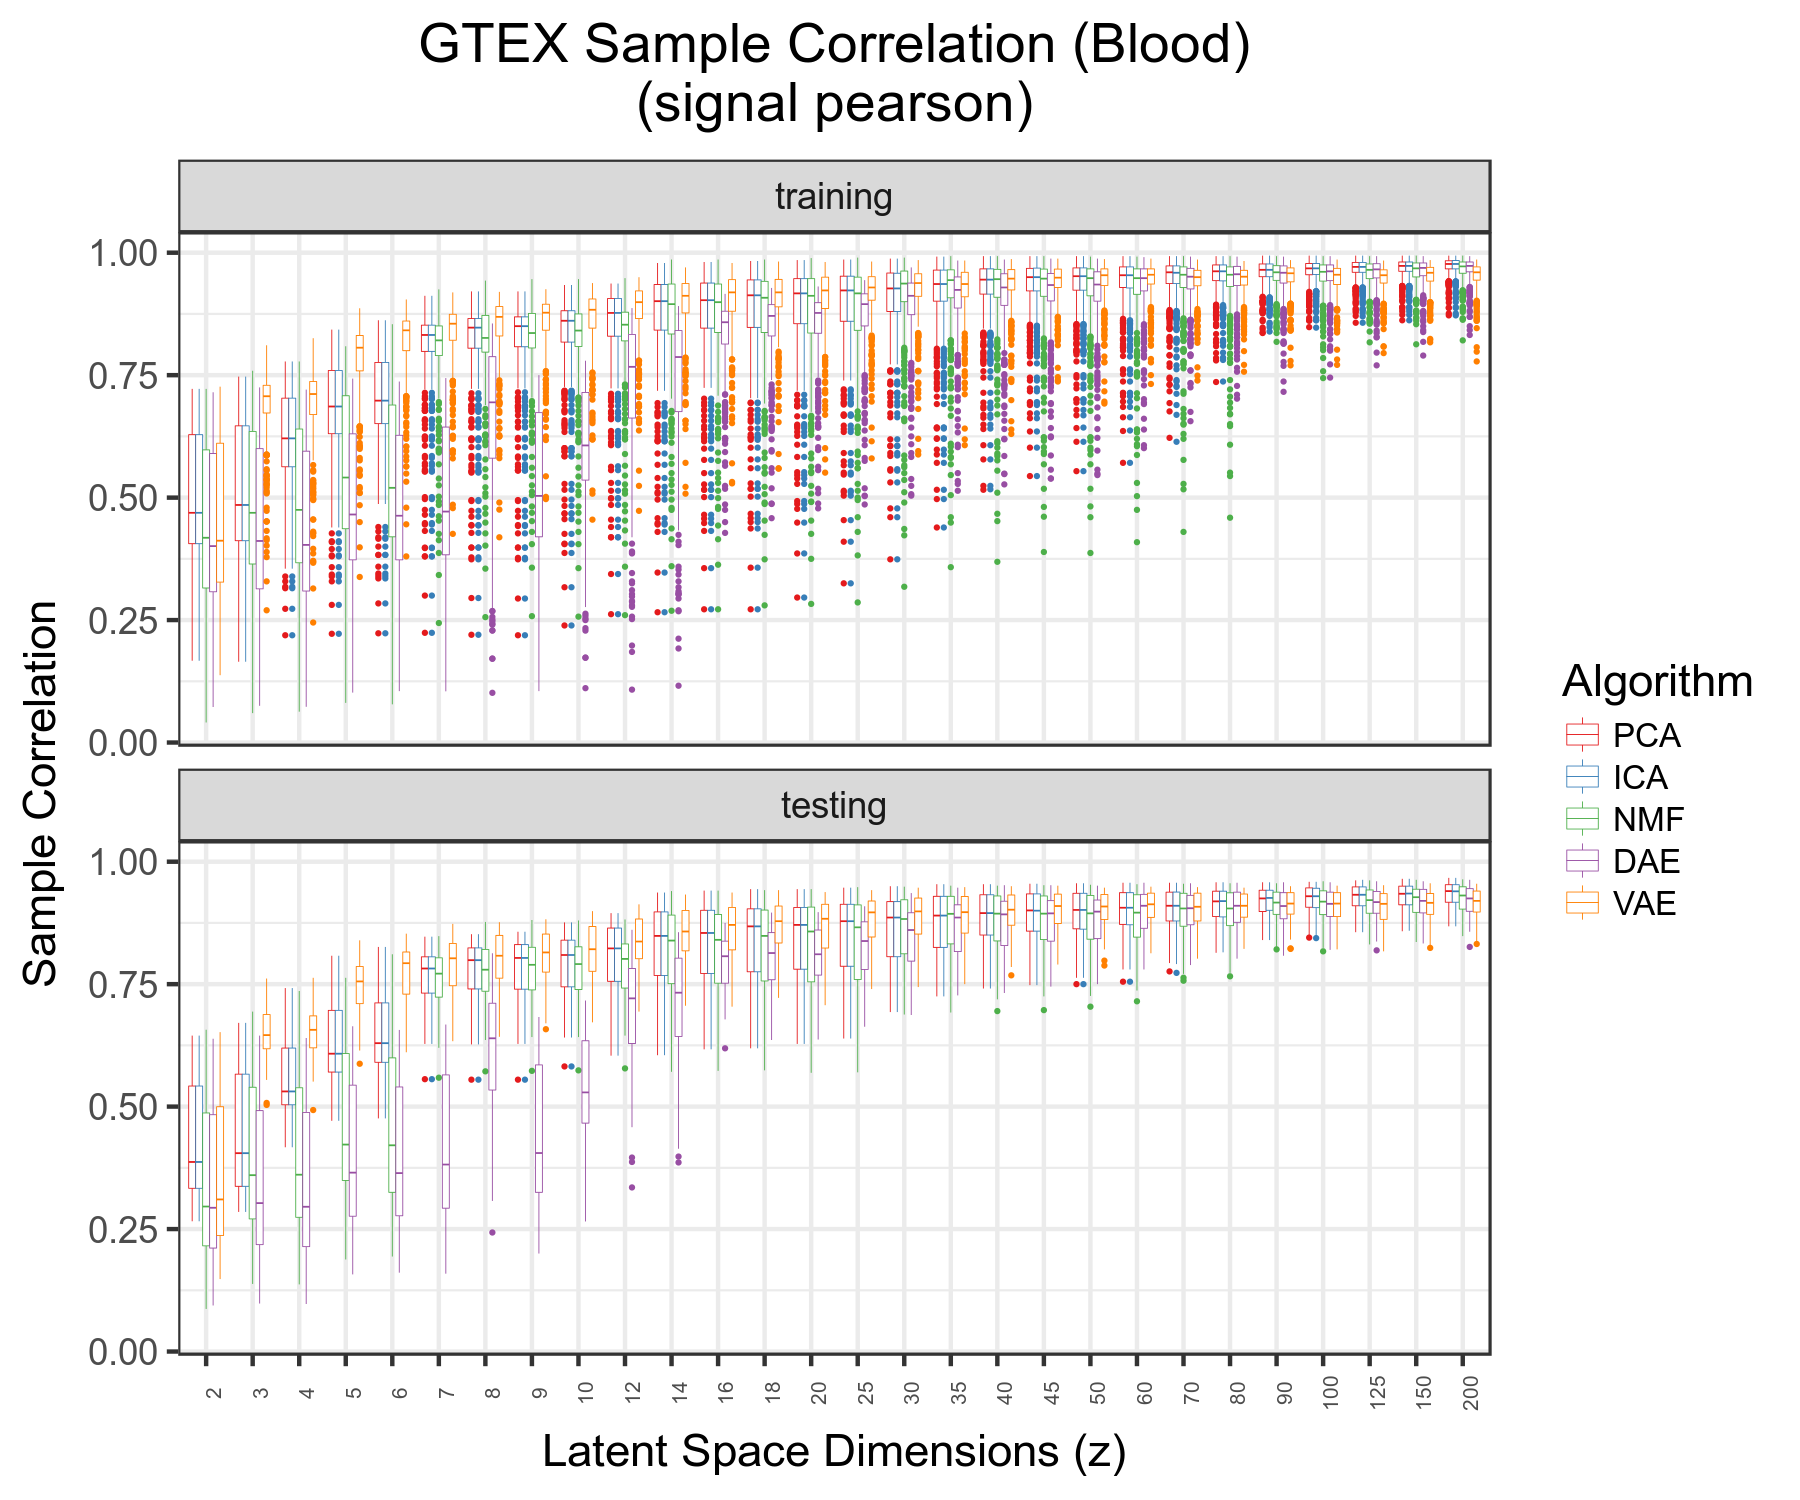

## Procedure

In the following notebook, we extract two representative weight matrices for VAE latent space dimensions 2 and 3.
We apply our matrix interpretation approach to the weight vectors for each latent space feature.
We also apply GSEA.

In both approaches we use genesets derived in the XCELL paper that represent cell-types ([Aran et al. 2017](https://doi.org/10.1186/s13059-017-1349-1))

We output the results of both approaches and analyze the results in subsequent notebooks.

In [1]:
import os
import glob
import requests
import pandas as pd
import numpy as np
import gseapy as gp

from scripts.latent import latentModel, load_hetnets, parse_gmt, run_gsea_prerank

In [2]:
np.random.seed(123)

In [3]:
metaedge = 'GpXCELL'

In [4]:
base_dir = '../2.ensemble-z-analysis/results/GTEX_results/ensemble_z_matrices/'

In [5]:
sample_weight_2 = os.path.join(base_dir, 'gtex_components_2', 'model_109635_weight_matrix.tsv.gz')
sample_weight_3 = os.path.join(base_dir, 'gtex_components_3', 'model_174930_weight_matrix.tsv.gz')

In [6]:
sample_weight_2_df = pd.read_table(sample_weight_2, index_col=0)
sample_weight_3_df = pd.read_table(sample_weight_3, index_col=0)

sample_weight_2_df = sample_weight_2_df.loc[:, sample_weight_2_df.columns.str.contains('vae')]
sample_weight_3_df = sample_weight_3_df.loc[:, sample_weight_3_df.columns.str.contains('vae')]

sample_weight_2_df.head()

,vae_0,vae_1
3043,0.172343,-0.227981
3040,0.155789,-0.227012
6280,-0.031052,-0.212339
5644,0.192519,-0.264237
2512,-0.029802,0.060251


In [7]:
combined_model = sample_weight_2_df.merge(sample_weight_3_df,
                                          left_index=True,
                                          right_index=True,
                                          suffixes=('_two', '_three'))
combined_model.index = combined_model.index.astype('str')
combined_model.head(2)

,vae_0_two,vae_1_two,vae_0_three,vae_1_three,vae_2
3043,0.172343,-0.227981,0.236818,-0.602538,-0.240952
3040,0.155789,-0.227012,0.213518,-0.589104,-0.245543


In [8]:
# Load hetnets for the given metaedge for rapid latent feature interpretation
hetnets = load_hetnets(
    hetnet_file='../3.build-hetnets/hetnets/interpret_hetnet.json.bz2',
    permuted_directory='../3.build-hetnets/hetnets/permuted/',
    subset_genes=combined_model.index,
    metaedge_abbrev=metaedge
   )

## Apply Interpret Compression Approach

In [9]:
%%time

mult_results = {}
all_list = []
for model in hetnets.keys():
    hetnet = hetnets[model]
    mult_results[model] = combined_model.T @ hetnet
    long_result = mult_results[model].reset_index().melt(id_vars=['index'])
    long_result = long_result.assign(model=model)
    if model != 'real':
        long_result = long_result.assign(model_type='permuted')
    else:
        long_result = long_result.assign(model_type='real')
    all_list.append(long_result)

CPU times: user 3.8 s, sys: 4.04 ms, total: 3.8 s
Wall time: 3.87 s


In [10]:
all_df = pd.concat(all_list)
all_df.value = all_df.value.astype(float)
all_df.head()

,index,variable,value,model,model_type
0,vae_0_two,Adipocytes_ENCODE_1,-0.315539,0,permuted
1,vae_1_two,Adipocytes_ENCODE_1,0.283446,0,permuted
2,vae_0_three,Adipocytes_ENCODE_1,-0.345545,0,permuted
3,vae_1_three,Adipocytes_ENCODE_1,-0.324586,0,permuted
4,vae_2,Adipocytes_ENCODE_1,-0.462507,0,permuted


In [11]:
permuted_mean = (
    all_df
    .groupby(['model_type', 'index', 'variable'])
    .mean()
    .reset_index()
    .query("model_type == 'permuted'")
)

permuted_std = (
    all_df
    .groupby(['model_type', 'index', 'variable'])
    .std()
    .reset_index()
    .query("model_type == 'permuted'")
)

real_df = (
    all_df
    .groupby(['model_type', 'index', 'variable'])
    .mean()
    .reset_index()
    .query("model_type == 'real'")
)


In [12]:
z_score = (real_df.reset_index(drop=True).value - permuted_mean.value) / permuted_std.value
real_df = real_df.reset_index(drop=True).assign(z_score=z_score)

real_df.head()

,model_type,index,variable,value,z_score
0,real,vae_0_three,Adipocytes_ENCODE_1,0.188528,2.214140
1,real,vae_0_three,Adipocytes_ENCODE_2,0.216554,2.116078
2,real,vae_0_three,Adipocytes_ENCODE_3,0.079694,1.543371
3,real,vae_0_three,Adipocytes_FANTOM_1,0.406027,2.878554
4,real,vae_0_three,Adipocytes_FANTOM_2,0.406027,6.245608


In [13]:
file = os.path.join('results', 'interpret_compression_gtex_vae_example.tsv')
real_df.sort_values(by='z_score').to_csv(file, sep='\t')

## Apply GSEA to the same features

In [14]:
vae_2_lm = latentModel(filename=sample_weight_2,
                       z_dim=2,
                       dataset_name='GTEX',
                       algorithm_name='VAE',
                       weight_seed='109635',
                       shuffled_true=False)

vae_3_lm = latentModel(filename=sample_weight_3,
                       z_dim=2,
                       dataset_name='GTEX',
                       algorithm_name='VAE',
                       weight_seed='174930',
                       shuffled_true=False)

In [15]:
xcell_gmt = parse_gmt(gene_sets=['../3.build-hetnets/data/xcell_all_entrez.gmt'])
len(xcell_gmt)

489

In [16]:
%%time
vae_feature_0_zdim_2 = run_gsea_prerank(gene_score_df=vae_2_lm.w_df.vae_0,
                                        gene_sets=xcell_gmt,
                                        permutation_num=1000)

vae_feature_1_zdim_2 = run_gsea_prerank(gene_score_df=vae_2_lm.w_df.vae_1,
                                        gene_sets=xcell_gmt,
                                        permutation_num=1000)

vae_feature_0_zdim_3 = run_gsea_prerank(gene_score_df=vae_3_lm.w_df.vae_0,
                                        gene_sets=xcell_gmt,
                                        permutation_num=1000)

vae_feature_1_zdim_3 = run_gsea_prerank(gene_score_df=vae_3_lm.w_df.vae_1,
                                        gene_sets=xcell_gmt,
                                        permutation_num=1000)

vae_feature_2_zdim_3 = run_gsea_prerank(gene_score_df=vae_3_lm.w_df.vae_2,
                                        gene_sets=xcell_gmt,
                                        permutation_num=1000)

CPU times: user 18.2 s, sys: 682 ms, total: 18.8 s
Wall time: 8min 5s


In [17]:
vae_feature_0_zdim_2 = vae_feature_0_zdim_2.assign(z_dim=2, feature=0)
vae_feature_1_zdim_2 = vae_feature_1_zdim_2.assign(z_dim=2, feature=1)

vae_feature_0_zdim_3 = vae_feature_0_zdim_3.assign(z_dim=3, feature=0)
vae_feature_1_zdim_3 = vae_feature_1_zdim_3.assign(z_dim=3, feature=1)
vae_feature_2_zdim_3 = vae_feature_2_zdim_3.assign(z_dim=3, feature=2)

In [18]:
gsea_results_df = pd.concat([
    vae_feature_0_zdim_2,
    vae_feature_1_zdim_2,
    vae_feature_0_zdim_3,
    vae_feature_1_zdim_3,
    vae_feature_2_zdim_3
])

gsea_results_df.head()

,fdr,geneset_size,z_dim,feature
Term,,,,
Hepatocytes_FANTOM_3,0.0,159,2,0
Keratinocytes_HPCA_2,0.0,52,2,0
Keratinocytes_HPCA_3,0.0,45,2,0
Keratinocytes_FANTOM_1,0.0,97,2,0
Keratinocytes_ENCODE_1,0.0,25,2,0


In [19]:
file = os.path.join('results', 'gsea_gtex_vae_example.tsv')
gsea_results_df.sort_values(by='fdr').to_csv(file, sep='\t')